# Dojo ANN with SMOTE

This notebook contains implementation with SMOTE for oversampling data since I don't get accuracy higher than 0.815-ish. Turns out, using oversampling method make my accuracy goes boom boom boom duerrr making it stuck on 0.7-ish and oftenly 0.5

In [147]:
import tensorflow;
import pandas;
from sklearn.model_selection import train_test_split;
from tensorflow import keras;
from tensorflow.keras.models import Sequential;
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt;
# from sklearn.decomposition import PCA;
from tensorflow.keras.utils import plot_model;
# from tensorflow.keras.regularizers import l2;
import requests;
import time;

from imblearn.over_sampling import SMOTE;

In [148]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Import

In [149]:
# Loading data from pre-cleaned csv file
current_folder = "/mnt/d/Code/College/Machine Learning/Team Assignment/Default Credit Scoring/";
# current_folder = "";
dataframe = pandas.read_csv(current_folder + "credit_card_clients.csv");

dataframe = dataframe.drop(columns = ["ID"]);

dataframe.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,LABEL
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
oversample = SMOTE(random_state = 42);

X_resampled, y_resample = oversample.fit_resample(
    dataframe.drop(columns = ["LABEL"]), 
    dataframe["LABEL"]
);

print("Generated ", len(y_resample), " data");

X_resampled["LABEL"] = y_resample;
resampled_data = X_resampled;

print(X_resampled)

dataframe = pandas.concat([dataframe, resampled_data], ignore_index = True);
dataframe.head()
dataframe.shape

## Feature Correlation

In this section I set the treshold with 0.2. Any feature below 0.2 will be discarded.

In [150]:
# Correlation Heatmap
correlation = dataframe.corr();

TRESHOLD = 0;
print("Relationship : Correlation Score");

columns_to_be_dropped = [];
for i in correlation.columns:
    correlation_score = correlation[i]["LABEL"];
    print(i, "-> LABEL : ", correlation_score);

    # When data are oversampled, Education seems more uncorrelated through the LABEL. Skipping drop the Education.
    if(i == "EDUCATION"):
        continue;

    if(correlation_score < TRESHOLD):
        columns_to_be_dropped.append(i);
        print("Dropping ", i);

dataframe = dataframe.drop(columns=columns_to_be_dropped);

Relationship : Correlation Score
LIMIT_BAL -> LABEL :  -0.1535198763935072
Dropping  LIMIT_BAL
SEX -> LABEL :  -0.03996057770544172
Dropping  SEX
EDUCATION -> LABEL :  0.028006077656250204
MARRIAGE -> LABEL :  -0.024339215683404438
Dropping  MARRIAGE
AGE -> LABEL :  0.013889834301962887
PAY_0 -> LABEL :  0.32479372847862237
PAY_2 -> LABEL :  0.2635512016721678
PAY_3 -> LABEL :  0.23525251372491712
PAY_4 -> LABEL :  0.21661363684242388
PAY_5 -> LABEL :  0.2041489138761645
PAY_6 -> LABEL :  0.18686636165354611
BILL_AMT1 -> LABEL :  -0.019644197143221562
Dropping  BILL_AMT1
BILL_AMT2 -> LABEL :  -0.014193218088215756
Dropping  BILL_AMT2
BILL_AMT3 -> LABEL :  -0.014075518043214726
Dropping  BILL_AMT3
BILL_AMT4 -> LABEL :  -0.010156495880289674
Dropping  BILL_AMT4
BILL_AMT5 -> LABEL :  -0.006760463841014779
Dropping  BILL_AMT5
BILL_AMT6 -> LABEL :  -0.005372314914815558
Dropping  BILL_AMT6
PAY_AMT1 -> LABEL :  -0.07292948777785163
Dropping  PAY_AMT1
PAY_AMT2 -> LABEL :  -0.05857870658290157

## Data Pre-Processing
Checkout the `main.ipynb` since I just copy-pasting the whole thing from it.

In [ ]:
# Some education data contains 0, 5, and 6. I eliminating "em.

invalid_education_data = [];
for idx, e in enumerate(dataframe['EDUCATION']):
    if(e > 4 or e < 1):
        invalid_education_data.append(idx);

invalid_pay_data = [];

for i in [dataframe['PAY_0'], dataframe['PAY_2'], dataframe['PAY_3'], dataframe['PAY_4'], dataframe['PAY_5'], dataframe['PAY_6']]:
    for idx, e in enumerate(i):
        if(e > 9 or e < -1):
            invalid_pay_data.append(idx);

final_invalid_data_index = [];
for e in [invalid_pay_data, invalid_education_data]:
    for f in e:
        
        # Check the index. If it throw exception, append the number. 
        try:
            final_invalid_data_index.index(f)
            continue
        except:
            final_invalid_data_index.append(f)


for i in final_invalid_data_index:
    dataframe = dataframe.drop(i);

# Make one hot encoding for Educuation and PAY_0 to 6 since the data is an ordinal data
hot_encoded_education = pandas.get_dummies(dataframe['EDUCATION'], prefix = "education");
hot_encoded_pay_0 = pandas.get_dummies(dataframe['PAY_0'], prefix = "pay_0");
hot_encoded_pay_2 = pandas.get_dummies(dataframe['PAY_2'], prefix = "pay_2");
hot_encoded_pay_3 = pandas.get_dummies(dataframe['PAY_3'], prefix = "pay_3");
hot_encoded_pay_4 = pandas.get_dummies(dataframe['PAY_4'], prefix = "pay_4");
hot_encoded_pay_5 = pandas.get_dummies(dataframe['PAY_5'], prefix = "pay_5");
hot_encoded_pay_6 = pandas.get_dummies(dataframe['PAY_6'], prefix = "pay_6");

# Merge the hot_encoded with the main dataframe
for i in [hot_encoded_education, hot_encoded_pay_0, hot_encoded_pay_2, hot_encoded_pay_3, hot_encoded_pay_4, hot_encoded_pay_5, hot_encoded_pay_6]:
    dataframe = pandas.concat([dataframe, i], axis = 1);

print("Data after cleaning: ", dataframe.shape);
print(dataframe.columns.tolist());

In [152]:
# Define label data
label = dataframe['LABEL'];

# Drop ID, SEX, EDUCATION, MARRIAGE, and LABEL from dataframe for features
features = dataframe.drop(columns=["EDUCATION", 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', "LABEL"]);

# Typecasting all values within to int64 because ANN need to be standardized

for i in dataframe.columns:
    dataframe[i] = dataframe[i].astype(int);

# Split the data into training, validation, and testing sets
feature_train, feature_test, label_train, label_test = train_test_split(features, label, train_size = 0.7, test_size = 0.3, random_state = 42);
feature_validation, feature_test, label_validation, label_test = train_test_split(feature_test, label_test, test_size=0.5, random_state = 42);

# Scale the features
scaler = StandardScaler();
feature_train_scaled = scaler.fit_transform(feature_train);
feature_validation_scaled = scaler.fit_transform(feature_validation);
feature_test_scaled = scaler.transform(feature_test);

In [153]:
def telegram_reporter(message):
    message = "["+ time.strftime("%Y-%m-%d %H:%M:%S") +"] " + message
    requests.request(method="POST", url="https://api.telegram.org/bot:bot_id/sendMessage?chat_id=:chat_id&text=" + message, headers={}, data={});

## Fine Tunning

This code based on Tensorflow Artifical Neural Network.

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_278 (Dense)           (None, 128)               8960      
                                                                 
 activation_47 (Activation)  (None, 128)               0         
                                                                 
 dense_279 (Dense)           (None, 64)                8256      
                                                                 
 activation_48 (Activation)  (None, 64)                0         
                                                                 
 dense_280 (Dense)           (None, 64)                4160      
                                                                 
 dense_281 (Dense)           (None, 16)                1040      
                                                                 
 dense_282 (Dense)           (None, 8)               

2024-01-20 19:58:46.010378: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



649/649 [==============================] - 8s 8ms/step - loss: 0.6461 - accuracy: 0.8139 - val_loss: 0.5726 - val_accuracy: 0.8118


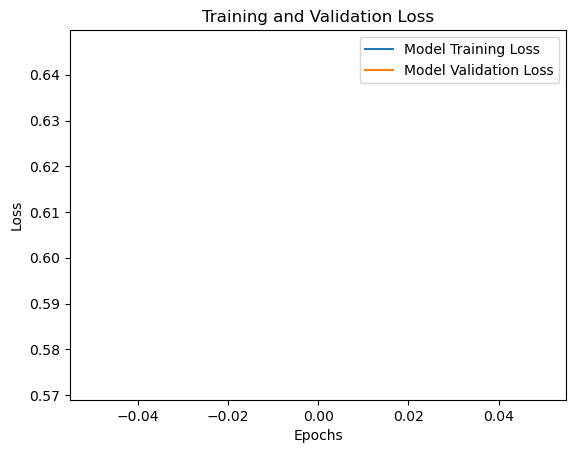

140/140 [==============================] - 1s 3ms/step - loss: 0.5685 - accuracy: 0.8161
Loss:  0.5685026049613953  Accuracy:  0.8161384463310242


In [156]:
class ANNModel:

    # Hyperparameters
    def input_layer(self):
        return keras.layers.InputLayer(input_shape = (65,)); # 11 is total features dimension

    def hidden_layer(self):
        return [
            keras.layers.Dense(128, kernel_initializer = "he_normal", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Activation("tanh"),
            keras.layers.Dense(64, kernel_initializer = "he_normal", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-3)),
            keras.layers.Activation("tanh"),
            keras.layers.Dense(64, kernel_initializer = "he_normal", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-3)),
        ];

    def no_activation_hidden_layer(self):
        return [
            # keras.layers.Dense(512, kernel_initializer = 'he_normal', kernel_regularizer = tensorflow.keras.regularizers.l2(1e-2)),
            # keras.layers.Activation("relu"),
            # keras.layers.Dense(256, kernel_initializer = 'he_normal', kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            # keras.layers.Activation("relu"),
            # keras.layers.Dense(256, kernel_initializer = 'he_normal',kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Dense(16, activation = 'relu'),
            keras.layers.Dense(8, activation = 'relu'),
            keras.layers.Dense(8, activation = 'relu'),
            keras.layers.Dense(4, activation = 'relu'),
            keras.layers.Dense(4, activation = 'relu'),
            keras.layers.Dense(4, activation = 'relu'),
            keras.layers.Dense(4, activation = 'relu'),
        ];

    def shallow_hidden_layer(self):
        return [
            keras.layers.Dense(16, kernel_initializer = "he_normal", activation = "tanh"),
            keras.layers.Dense(8, kernel_initializer = "he_normal", activation = "tanh"),
            keras.layers.Dense(8, kernel_initializer = "he_normal", activation = "tanh"),
        ];

    def output_layer(self):
        return keras.layers.Dense(1, activation = "sigmoid"); # Since output is only 1 label.

    def optimizer(self):
        return keras.optimizers.Adam(learning_rate = 1e-3);

    def loss(self):
        return "binary_crossentropy";

    def metrics(self):
        return "accuracy";

    def epoch(self):
        return 1;

        
    # Callbacks
    # Backup Model to h5 file
    def _callback_model_backup(self):
        checkpoint_path = current_folder + "/cua/" + "model_checkpoint.h5";

        return tensorflow.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=True,
            save_freq='epoch'
        );

    # Early stopping after loss are not improved for some epochs
    def _callback_early_stopping(self):
        early_stopping_tolerance = 50;

        return tensorflow.keras.callbacks.EarlyStopping(
            monitor = "val_loss",
            patience = early_stopping_tolerance,
            restore_best_weights = True
        );

    # Fitting
    def fit(self):

        # Construct the model 
        model = Sequential();
        model.add(self.input_layer());

        for i in [self.hidden_layer(), self.shallow_hidden_layer()]:
            for j in i:
                model.add(j);

        model.add(self.output_layer());

        # Draw the model architecture
        plot_model(model, to_file=(current_folder + "/cua/" + "model_architecture.png"), show_shapes=True)
        model.summary()

        # Compile the model pipeline
        model.compile(loss = self.loss(), optimizer = self.optimizer(), metrics=[self.metrics()]);

        telegram_reporter("Starting training model with code [202401200128] with total epoch of " + str(self.epoch()));

        # Fitting
        model_plot = model.fit(
            feature_train_scaled, 
            label_train, 
            epochs = self.epoch(), 
            validation_data = (feature_validation_scaled, label_validation), 
            callbacks = [self._callback_model_backup(), self._callback_early_stopping()] 
        );

        plt.plot(model_plot.history["loss"], label = "Model Training Loss");
        plt.plot(model_plot.history["val_loss"], label = "Model Validation Loss");
        plt.title("Training and Validation Loss");
        plt.xlabel("Epochs");
        plt.ylabel("Loss");
        plt.legend();
        plt.show();

        return model;

dojo = ANNModel();
model = dojo.fit();

loss, accuracy = model.evaluate(feature_test_scaled, label_test);
print("Loss: ", loss, " Accuracy: ", accuracy);

telegram_reporter("Finished training with Loss: " + str(loss) + " Accuracy: " + str(accuracy));